#Scraps Type Classification using Transfer Learning - Xception

##1. Import Library and Dataset

In [1]:
import os
import zipfile
import shutil
from shutil import copyfile
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import Xception
from keras import layers
from keras import Model
import warnings
warnings.filterwarnings("ignore")
print(tf.__version__)

2.8.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/Shareddrives/recycraft/scraps-dataset"
%cd /content/drive/Shareddrives/recycraft/scraps-dataset/

Mounted at /content/drive
/content/drive/Shareddrives/recycraft/scraps-dataset


In [3]:
!kaggle datasets download -d mostafaabla/garbage-classification
!kaggle datasets download -d ashwinshrivastav/most-common-recyclable-and-nonrecyclable-objects
!kaggle datasets download -d techsash/waste-classification-data

garbage-classification.zip: Skipping, found more recently modified local copy (use --force to force download)
most-common-recyclable-and-nonrecyclable-objects.zip: Skipping, found more recently modified local copy (use --force to force download)
waste-classification-data.zip: Skipping, found more recently modified local copy (use --force to force download)


##2. Settings Hyperparameter

In [4]:
SPLIT_SIZE = 0.9
BATCH_SIZE = 32
INPUT_SIZE = (150, 150)
EPOCH = 20
N = 16

##3. Create Training & Validation Directory

In [5]:
root_path = '/content/drive/Shareddrives/recycraft/machine-learning/scraps-type-classification'

if os.path.exists(root_path):
  shutil.rmtree(root_path)

def create_train_val_dirs(root_path):
  training_dir = os.path.join(root_path, "training")
  validation_dir = os.path.join(root_path, "validation")
  os.makedirs(training_dir)
  os.makedirs(validation_dir)
  os.makedirs(os.path.join(training_dir, "organic"))
  os.makedirs(os.path.join(training_dir, "recycleable"))
  os.makedirs(os.path.join(validation_dir, "organic"))
  os.makedirs(os.path.join(validation_dir, "recycleable"))
try:
  create_train_val_dirs(root_path)
  print("Succesfull !")
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

for rootdir, dirs, files in os.walk(root_path):
  for subdir in dirs:
    print(os.path.join(rootdir, subdir))

Succesfull !
/content/drive/Shareddrives/recycraft/machine-learning/scraps-type-classification/training
/content/drive/Shareddrives/recycraft/machine-learning/scraps-type-classification/validation
/content/drive/Shareddrives/recycraft/machine-learning/scraps-type-classification/training/organic
/content/drive/Shareddrives/recycraft/machine-learning/scraps-type-classification/training/recycleable
/content/drive/Shareddrives/recycraft/machine-learning/scraps-type-classification/validation/organic
/content/drive/Shareddrives/recycraft/machine-learning/scraps-type-classification/validation/recycleable


##4. Splitting Dataset

In [6]:
def split_data(SOURCE, TRAINING, VALIDATION, SPLIT_SIZE):
  files = []
  for filename in os.listdir(SOURCE):
    file = SOURCE + filename
    if os.path.getsize(file) > 0:
      files.append(filename)
    else:
      print(f"{filename} memiliki ukuran 0 sehingga dilewatkan.")
      
  training_len = int(len(files) * SPLIT_SIZE)
  validation_len = int(len(files) - training_len)
  shuffle_set = random.sample(files, len(files))
  training_set = shuffle_set[0:training_len]
  validation_set = shuffle_set[-validation_len:]
  
  for filename in training_set:
    source = SOURCE + filename
    destiny = TRAINING + filename
    copyfile(source, destiny)

  for filename in validation_set:
    source = SOURCE + filename
    destiny = VALIDATION + filename
    copyfile(source, destiny)

In [7]:
#source path
organic_source_path = '/content/drive/Shareddrives/recycraft/scraps-dataset/scraps-source/organic/'
recycleable_source_path = '/content/drive/Shareddrives/recycraft/scraps-dataset/scraps-source/recycleable/'

#training & testing path
training_dir = '/content/drive/MyDrive/scraps-type-classification/training/'
validation_dir = '/content/drive/MyDrive/scraps-type-classification/validation'

#destiny path
organic_training_dir = os.path.join(training_dir, 'organic/')
organic_validation_dir = os.path.join(validation_dir, 'organic/')
recycleable_training_dir = os.path.join(training_dir, 'recycleable/')
recycleable_validation_dir = os.path.join(validation_dir, 'recycleable/')

if len(os.listdir(organic_training_dir)) > 0:
  for file in os.scandir(organic_training_dir):
    os.remove(file.path)
if len(os.listdir(organic_validation_dir)) > 0:
  for file in os.scandir(organic_validation_dir):
    os.remove(file.path)
if len(os.listdir(recycleable_training_dir)) > 0:
  for file in os.scandir(recycleable_training_dir):
    os.remove(file.path)
if len(os.listdir(recycleable_validation_dir)) > 0:
  for file in os.scandir(recycleable_validation_dir):
    os.remove(file.path)

split_data(organic_source_path, organic_training_dir, organic_validation_dir, SPLIT_SIZE)
split_data(recycleable_source_path, recycleable_training_dir, recycleable_validation_dir, SPLIT_SIZE)

print(f"\nAda {len(os.listdir(organic_training_dir))} gambar organic materials pada training ")
print(f"Ada {len(os.listdir(organic_validation_dir))} gambar organic materials pada validation ")
print(f"Ada {len(os.listdir(recycleable_training_dir))} gambar recycleable materials pada training ")
print(f"Ada {len(os.listdir(recycleable_validation_dir))} gambar recycleable materials pada validation ")


Ada 9448 gambar organic materials pada training 
Ada 1050 gambar organic materials pada validation 
Ada 9366 gambar recycleable materials pada training 
Ada 1041 gambar recycleable materials pada validation 


##5. Training Validation Generator and Data Augmentation

In [8]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range = 40,
                                     width_shift_range = 0.2,
                                     height_shift_range = 0.2,
                                     shear_range = 0.2,
                                     zoom_range = 0.2,
                                     horizontal_flip = True,
                                     fill_mode = 'nearest'
                                     )
  train_generator = train_datagen.flow_from_directory(directory = TRAINING_DIR,
                                                      batch_size = BATCH_SIZE,
                                                      class_mode = 'categorical',
                                                      target_size = INPUT_SIZE)
  validation_datagen = ImageDataGenerator(rescale=1./255)
  validation_generator = validation_datagen.flow_from_directory(directory =VALIDATION_DIR,
                                                                batch_size = BATCH_SIZE,
                                                                class_mode = 'categorical',
                                                                target_size = INPUT_SIZE)
  return train_generator, validation_generator

In [9]:
train_generator, validation_generator = train_val_generators(training_dir, validation_dir)

Found 18806 images belonging to 2 classes.
Found 2090 images belonging to 2 classes.


##6. Create Model using Transfer Learning

In [10]:
pretrained_model = Xception(input_shape = (150, 150, 3),
                                include_top = False,
                                weights ='imagenet')

83697664/83683744 [==============================] - 1s 0us/step


In [11]:
for layer in pretrained_model.layers:
    layer.trainable = False
    
pretrained_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 74, 74, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                           

In [12]:
last_layer = pretrained_model.get_layer('add_11')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 5, 5, 1024)


In [13]:
x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(2, activation='sigmoid')(x)   
model = Model(pretrained_model.input, x)

In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 74, 74, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                              

##7. Training Data

In [15]:
history = model.fit(train_generator,
                    epochs = EPOCH, 
                    validation_data = validation_generator,
                    verbose=1)

Epoch 1/20
588/588 [==============================] - 193s 305ms/step - loss: 0.2986 - accuracy: 0.8945 - val_loss: 0.2093 - val_accuracy: 0.9144
Epoch 2/20
588/588 [==============================] - 154s 263ms/step - loss: 0.2175 - accuracy: 0.9176 - val_loss: 0.1796 - val_accuracy: 0.9359
Epoch 3/20
588/588 [==============================] - 151s 257ms/step - loss: 0.2011 - accuracy: 0.9232 - val_loss: 0.1702 - val_accuracy: 0.9349
Epoch 4/20
588/588 [==============================] - 151s 257ms/step - loss: 0.1886 - accuracy: 0.9283 - val_loss: 0.1639 - val_accuracy: 0.9388
Epoch 5/20
588/588 [==============================] - 151s 258ms/step - loss: 0.1870 - accuracy: 0.9295 - val_loss: 0.1712 - val_accuracy: 0.9383
Epoch 6/20
588/588 [==============================] - 151s 257ms/step - loss: 0.1794 - accuracy: 0.9315 - val_loss: 0.1524 - val_accuracy: 0.9445
Epoch 7/20
588/588 [==============================] - 152s 259ms/step - loss: 0.1725 - accuracy: 0.9319 - val_loss: 0.1544 -

##8. Plotting Accuracy and Model Evaluation

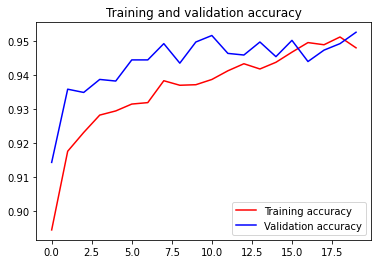

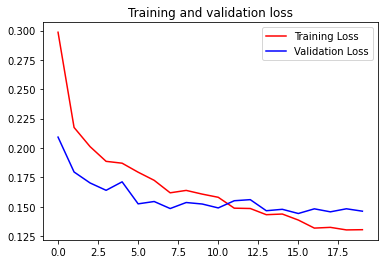

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [17]:
_, acc = model.evaluate_generator(validation_generator, steps=10, verbose=0)
print('Test Accuracy: %.3f ' % (acc * 100))

Test Accuracy: 95.312 


##9. Predict Data

Akurasi : 87.5 %


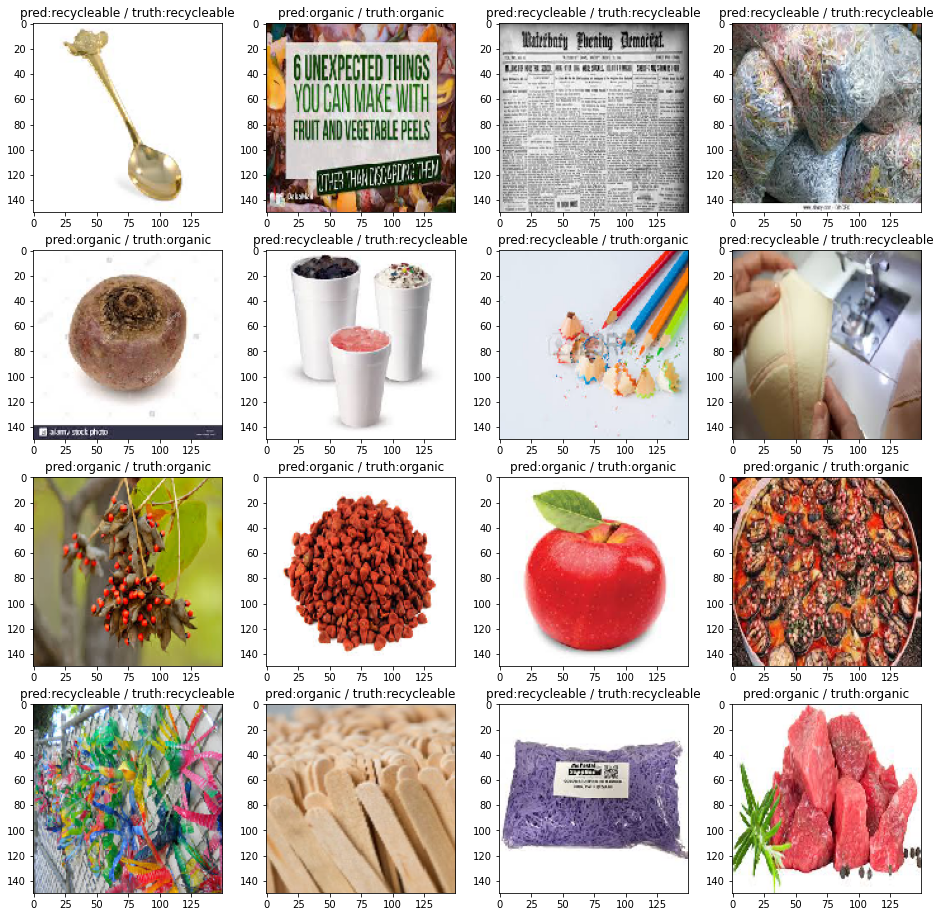

In [18]:
test_x, test_y = validation_generator.__getitem__(1)

labels = (validation_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

y_pred = model.predict(test_x)

plt.figure(figsize=(16, 16))
n = 16
count = 0
for i in range(n):
    plt.subplot(4, 4, i+1)
    plt.title('pred:%s / truth:%s' % (labels[np.argmax(y_pred[i])], labels[np.argmax(test_y[i])]))
    plt.imshow(test_x[i])
    if (np.argmax(y_pred[i]) == np.argmax(test_y[i])):
      count += 1
akurasi = count/n*100
print('Akurasi : {} %'.format(akurasi))

##10. Save Model and Convert to TFLite

In [23]:
saved_model_path = "/content/drive/MyDrive/saved_model/stc_best_model.h5"

In [24]:
model.save(saved_model_path)

In [27]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpt0mhqzai/assets


In [28]:
import pathlib

tflite_model_file = pathlib.Path('/content/drive/MyDrive/saved_model/stc_best_model.tflite')
tflite_model_file.write_bytes(tflite_model)
print("Model successfully created in .tflite!")

Model successfully created in .tflite!
